# Call Tree Implementation

In [34]:
import numpy as np
from math import isnan
import threading as trd
import math
import random as rnd
import copy
    

from DensityTree import RandomDensityTree

# The Clustering Tree
Unlike the more commonly used classification or regression forest, density forest use a clustering tree which uses a measure of information gain based around "closeness" of the data point. The split determines how the data is divided into clusters. This means the closer each point in the cluster is to one another other after splitting, the higher the information gain. <br><br>
Each cluster is assumed to contain data that is distributed in a gaussian way. To estimate the gaussians at each cluster, one simply needs to compute the mean and covariance matrix of the data contained in that leaf node. The entire tree is therefore comparable to a mixture of gaussians but with the splits representing hard cut-off lines for each gaussian estimation. Due to the cut-offs, the results have to be normalized by a nurmalization term defined by a partition function. The forest will later average the gaussian estimation of all the trees it contains.

## This Implementation

The first idea was to use and modify the already existing sklearn implementation of Decision Trees. Our first attempts however showed it to be more difficult than expected. Additionally, another group had alreay been working on on a clustering tree, meaning that a significant part of our work hd to either be copied or repeated. We therefore decided to first of all focus on implementing our own version of a clustering tree. While the sklearn implementation implementation uses cython, this implementation only uses plain 'vanilla' python along with several of its most commonly packages.  While this implementation is naturally slower and in many ways less versatile than the sklearn imprementation, it also allowed us to implement some interesting features for better visualization of the data. This includes lists that keep track of all the splits in the tree as well as functions that immediately allow the retrieval of means and data covariances per leaf. Additionally, our tree allows us to perform non-axis aligned liner splits which were not even mentioned in the original paper.<br><br>
The tree is implemented as a number of node-objects which in the case of internal nodes contain references to each of thier two child nodes. During training the node gerentates a number of random splits whose values are between between the minimum and maximum value of the training data. It then decides one the best one by choosing the split with maximal information gain. If the information gain does not exceed a ceratin value, the data will not be split. This value is typically very small but can be increased or decreased if given to the tree generating function as an optional parameter. The split will also not occur if the tree is currently at its max length or when the number of data points in a node after the split is less then two. The reson for this being that no covariance matrices can be computed for less than two data oints. Otherwise, the the node will divide the data based on the split, create its two child nodes and tran them on the divided data sets in a recursive manner <br><br>
For ease of repeated access to each node, a reference to the node is also kapt in the 'tree' array at the position 'pointer'. This pointer int-value is usually what is retured in functions asking for a specific node or a number of nodes. The tree possesses wo such functions, the first being one that retrns all the leaf nodes and thus the end result of splitting the data. The second function predicts the cluster of an input value which is necessary for volume estimation in the partition function.  The partition function is estimated via a Monte Carlo-algorithm that is explained in[ another file].
<br><br>
At each node, a history of previous splits that lead up to that node is split for easier visualization later on. This history contains the values of each previous split along with the information whether the next node in the path history was a left or a right child node. Using all leaf nodes allows us to reconstruct the splits for the whole tree.

# Visualization

In [188]:
from matplotlib.patches import Ellipse

def plotsplits(h,s,hor=[0,6],vert=[0,6]):
   
        plotsplits(h,s+1,hor,vert) 


def plotaxis(data,DensityTree,xlim=[0,6],ylim=[0,6],title='test',showcov=True,vec1=[-1,0]):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xlim(xlim[0],xlim[1])

    nodes=DensityTree.leaf_nodes()
    tree=DensityTree.tree
    ax.plot(data[:,0],data[:,1], "o")
    
    for d in nodes:

        vert=xlim
        hor=ylim
        for h in tree[d].history:
           
            #plotsplits(h,0)
            if h['direction']==0:
                ax.plot([h['split'],h['split']],vert,color='k')
                if(h['child']=='left'):
                    hor=[hor[0],h['split']]
                else:
                    hor=[h['split'],hor[1]]
        
            else:
                ax.plot(hor,[h['split'],h['split']],color='k')
                if(h['child']=='left'):
                    vert=[vert[0],h['split']]
                else:
                    vert=[h['split'],vert[1]]
            
        if(showcov==True):
            if(len(tree[d].history)>2 and h['child']=='left'):
                vec1=[1,0]
            eigvals,eigvecs=np.linalg.eig(tree[d].cov)
    
            print((180/math.pi)*np.arccos(np.dot(eigvecs[0],vec1)/(np.linalg.norm(vec1)*np.linalg.norm(eigvecs[0]))))
            e=Ellipse(xy=tree[d].mean, width=math.sqrt(eigvals[0])*4, height=math.sqrt(eigvals[1])*4, angle=abs((180/math.pi)*np.arccos(np.dot(eigvecs[0],vec1)/(np.linalg.norm(vec1)*np.linalg.norm(eigvecs[0])))),alpha=0.5,edgecolor='none')
            ax.add_artist(e)

            plt.plot(tree[d].mean[0],tree[d].mean[1],'o',color='r')

    plt.show()
    

   # plt.savefig('results')
    
def plotlin(data,DensityTree,xlim=[0,6],ylim=[0,-1],title='test',showcov=True,vec1=[-1,0]):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xlim(xlim[0],xlim[1])

    nodes=DensityTree.leaf_nodes()
    tree=DensityTree.tree
    ax.plot(data[:,0],data[:,1], "o")
    for d in nodes:
        for h in tree[d].history:
            ax.plot([(h['split']+h['direction']*10)[0],(h['split']+h['direction']*-10)[0]],[(h['split']+h['direction']*10)[1],(h['split']+h['direction']*-10)[1]],color='k')
            ax.plot(h['split'][0],h['split'][1],"s",color='g')
        if(showcov==True):
            
            eigvals,eigvecs=np.linalg.eig(tree[d].cov)
            print(np.dot(eigvecs[0],vec1))
            e=Ellipse(xy=tree[d].mean, width=math.sqrt(eigvals[0])*4, height=math.sqrt(eigvals[1])*4, angle=(180/math.pi)*np.arccos(np.dot(eigvecs[0],vec1)/(np.linalg.norm(vec1)*np.linalg.norm(eigvecs[1]))),alpha=0.5,edgecolor='none')
            ax.add_artist(e)

            plt.plot(tree[d].mean[0],tree[d].mean[1],'o',color='r')

    plt.show()
#plotaxis(data,DensityTree,xlim=[0,6],ylim=[0,6])

# Simple Data Example
The following data will be used for a number of clustering tests. It contains 4 loosely seperated groups of data points. The idead ideal axis-aligned separation of th data would e achived by a tree of depth two, and the splits would be placed at areas of low density, resulting the seperation lines following a loose "plus"-shape. 

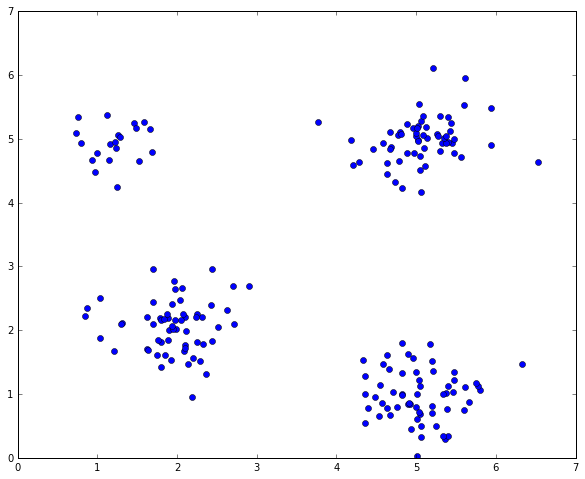

In [154]:
%matplotlib inline
import matplotlib.pyplot as plt

data = np.zeros([200,2])
for i in range(60):
    data[i]=np.random.normal([2,2],0.4)

for i in range(60):
    data[60+i]=np.random.normal([5,5],0.4)

for i in range(60):
    data[120+i]=np.random.normal([5,1],0.4)
   
for i in range(20):
    data[180+i]=np.random.normal([1,5],0.4)
plt.figure(figsize=(10,8))
plt.plot(data[:,0],data[:,1], "o")

plt.show()

# The "Perfect" Fit

The folowing image shows the actual splits computed by a Clustering Tree with depth 1. The seperating lines follow the expected pattern. Clustering would consist of a tree with two splits, which are placed at areas of low density. The second image shows the resulting means of the clusters as red dots and and a representation of the ellipsis corresponding to covariance. Please note that the ellipsis is not an exact representation of the variance and has a slightly smaller circumferene for the purpuse of avoiding to exceed the boundaries of the cluster. The length and width of the ellipsis are given as the eigenvalues of the covariance matrix multiplied by 3 and the direction of the width and length vectors is defined by its eigenvectors.

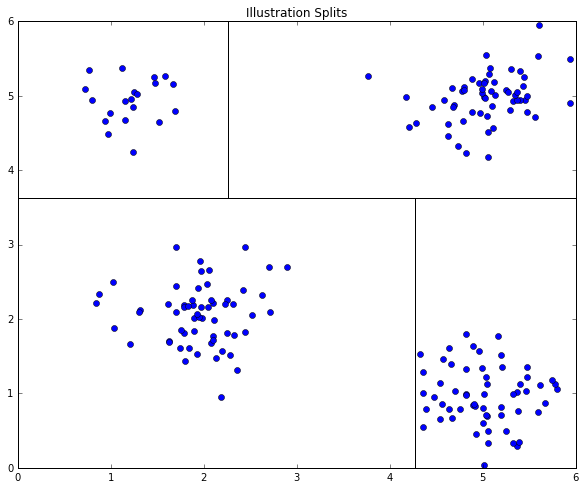

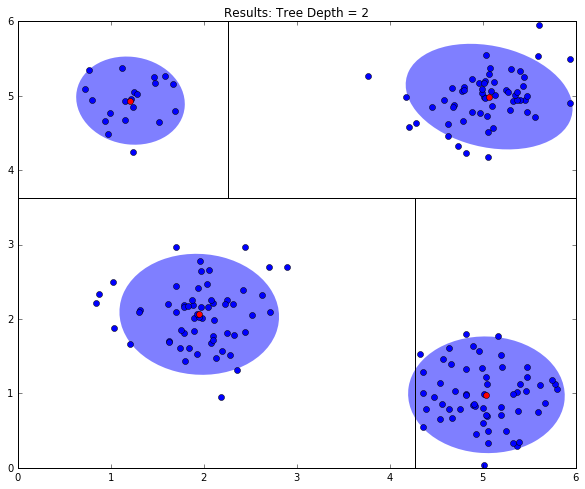

In [155]:
DensityTree1=RandomDensityTree(max_depth=2,min_infogain=0.2,num_splits=50)
DensityTree1.fit(data)

plotaxis(data,DensityTree1,xlim=[0,6],ylim=[0,6],showcov=False,title='Illustration Splits')
plotaxis(data,DensityTree1,xlim=[0,6],ylim=[0,6],title='Results: Tree Depth = 2')

#DensityTree2=RandomDensityTree(max_depth=2,splittype='linear',min_infogain=0.2,num_splits=400)
#DensityTree2.fit(data)

# Overfitting and Underfitting
The following images shows the effect of choosing too shallow or too deep trees for clustering. In the first image shows the clustering how it was estimated by a tree of depth 1, which severely underfits the data. This also showcases the fact that even if the separation itself is axis-alinged, the resultig gaussians are not. The image below shows a tree of depth 4 being being used to cluster the data. As is plainly visible, this tree noticably overfits the data. Overall shows the importance of values like tree depth when a single tree is concerned. In a forest where several trees are used and averaged, slight overfitting is less problematic.

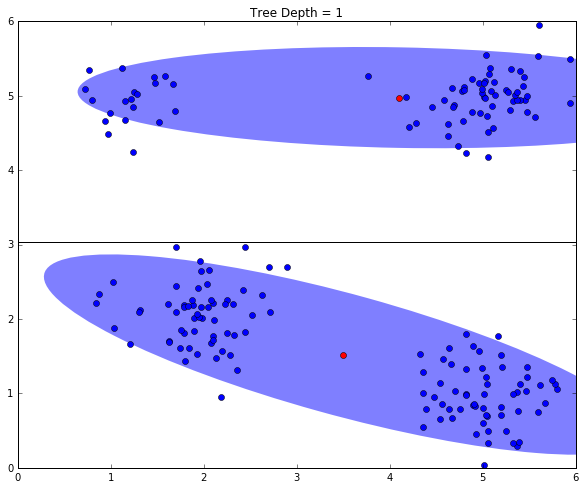

In [156]:
DensityTree2=RandomDensityTree(max_depth=1,min_infogain=0.2,num_splits=50)
DensityTree2.fit(data)
plotaxis(data,DensityTree2,xlim=[0,6],ylim=[0,6],title='Tree Depth = 1')


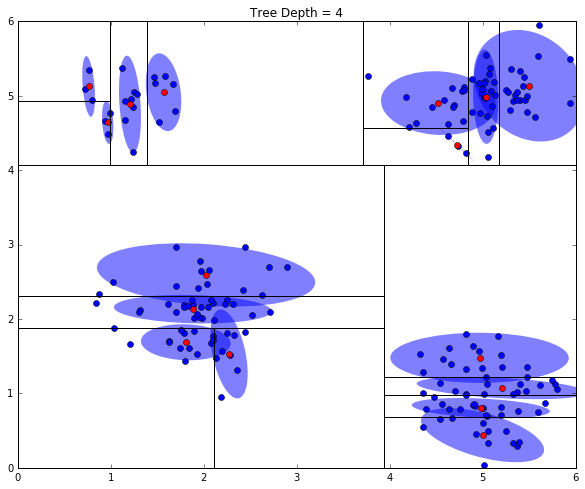

In [157]:
DensityTree3=RandomDensityTree(max_depth=4,min_infogain=0.001,num_splits=50)
DensityTree3.fit(data)
plotaxis(data,DensityTree3,xlim=[0,6],ylim=[0,6],title='Tree Depth = 4')




Instead of a fixed-depth tree, branches of varying depth are also possible. In the following 2 images, minimum information-gain is a more important criterium for splitting than maximum depth. With this specific minimum information gain chosen, we can end up with a slightly overfitted tree. The image below those two show how a perfect split can be achieved by choosing a specific information gain. Having knowledge of the task, data and context can therefore be very important, a similar truth holds for choosing the right depth.

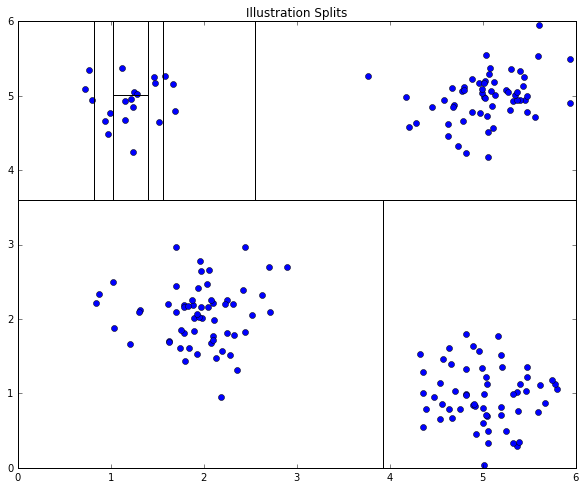

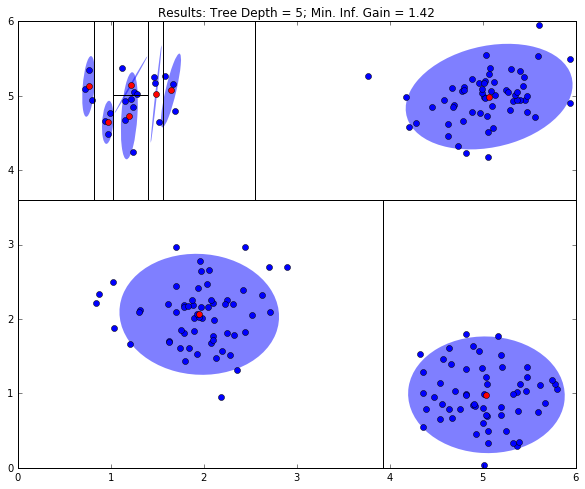

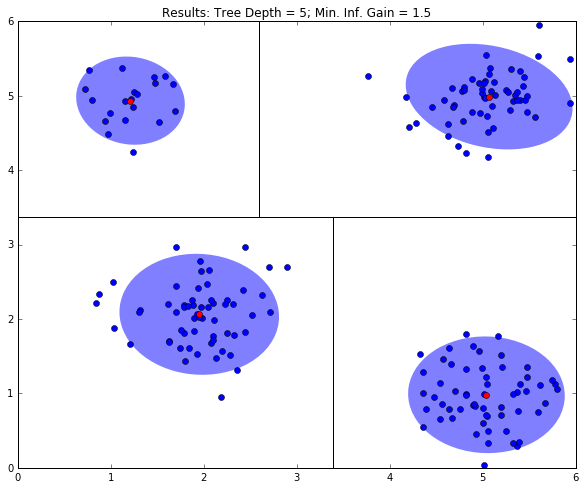

In [176]:
DensityTreeEx=RandomDensityTree(max_depth=5,min_infogain=1.4,num_splits=50)
DensityTreeEx.fit(data)
DensityTreeEx2=RandomDensityTree(max_depth=5,min_infogain=1.5,num_splits=50)
DensityTreeEx2.fit(data)

plotaxis(data,DensityTreeEx,xlim=[0,6],ylim=[0,6],showcov=False,title='Illustration Splits')
plotaxis(data,DensityTreeEx,xlim=[0,6],ylim=[0,6],title='Results: Tree Depth = 5; Min. Inf. Gain = 1.42')
plotaxis(data,DensityTreeEx2,xlim=[0,6],ylim=[0,6],title='Results: Tree Depth = 5; Min. Inf. Gain = 1.5')

# Linear Separation
The last image shows the effect of results of performing non-axis aligned linear separation while clustering. Our implementation uses random splits for linear separation as well, with origin points and directional vectors being randonly chosen. The first image shows the seperatrices with the green squares being the origin point of the separating vectors. The vectors in this visualization go all the way through, even though they actually restricted by previous splits. The origin points and clustering results allow us to reconstruct the vectors how they actually are. <br><br>
Also note that for this particular probem, many very differentdifferent non-linear separations exist. Using axis aligned splits is not actually better or more useful than  axis aligned splits for this problem. 

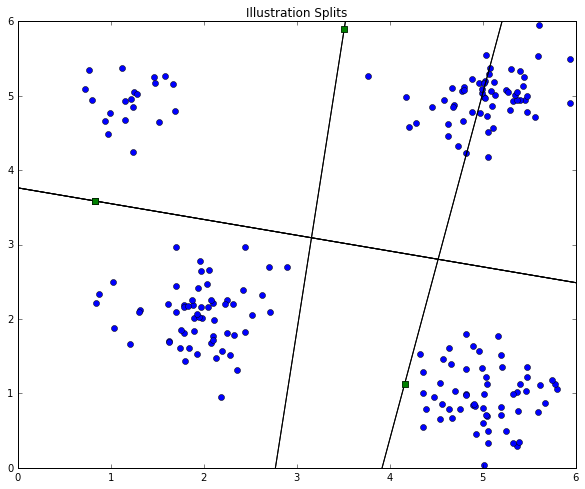

0.769467703317
-0.928366743636
-0.951885027474
-0.991776208341


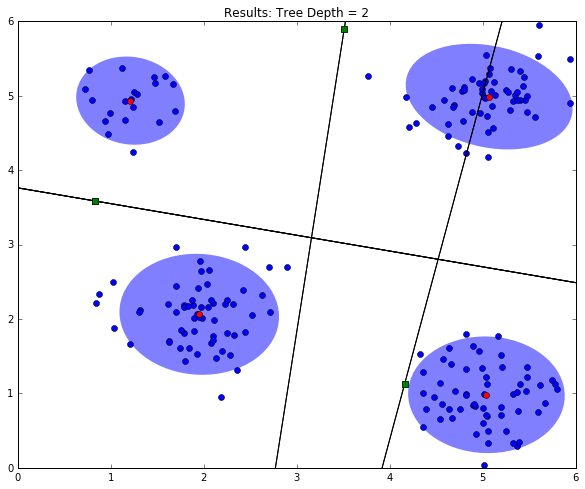

In [160]:
DensityTree5=RandomDensityTree(max_depth=2,min_infogain=0.2,num_splits=50,splittype='linear')
DensityTree5.fit(data)

plotlin(data,DensityTree5,xlim=[0,6],ylim=[0,6],showcov=False,title='Illustration Splits')
plotlin(data,DensityTree5,xlim=[0,6],ylim=[0,6],title='Results: Tree Depth = 2')

This is a reconstruction example of how the splits actuall look like, based on the previous visualizations.

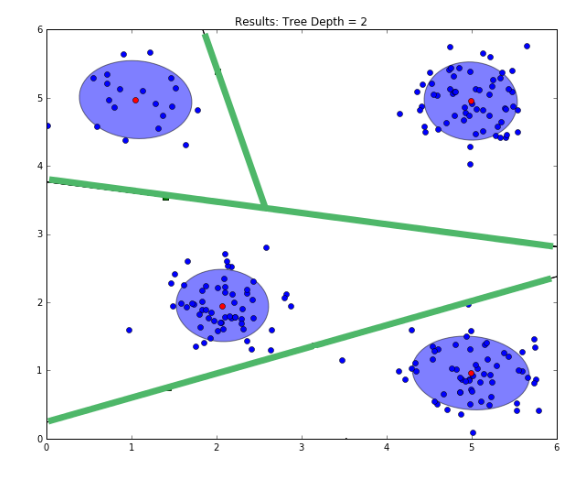

In [52]:
import matplotlib.image as mpimg
fig = plt.figure(figsize=(10,8),frameon=False)
img=mpimg.imread('realsplits.png')
plt.axis('off')
imgplot = plt.imshow(img)


# Other Visualizations

The following images show visualizations of splits for example data that we used

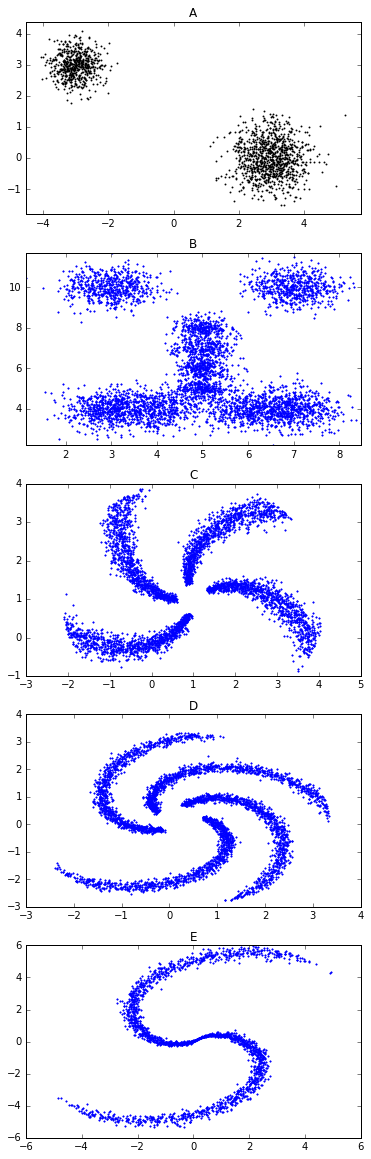

In [72]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture


plt.figure(figsize=(6, 20))
#plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=.95)


n_samples1 = 600
n_samples2 = 1000
# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
gaussian1 = 0.4*np.random.randn(n_samples1,2) + np.array([-3, 3])
gaussian2 = 0.6*np.random.randn(n_samples2,2) + np.array([3, 0])

X_train = np.vstack([gaussian1, gaussian2])


plt.subplot(511)
plt.scatter(X_train[:, 0], X_train[:, 1], .8)
plt.title('A')
plt.axis('tight')


obs = np.concatenate((np.array([3, 10])+0.5*np.random.randn(600, 2),
      np.array([7, 10])+ 0.5*np.random.randn(600, 2),
      np.array([5, 8]) + 0.3*np.random.randn(300, 2),
      np.array([5, 7]) + 0.3*np.random.randn(300, 2),
      np.array([5, 6])+ 0.3*np.random.randn(300, 2),
      np.array([5, 5])+ 0.3*np.random.randn(300, 2), 
      np.array([3, 4]) + 0.5*np.random.randn(600, 2),
      np.array([4, 4]) + 0.5*np.random.randn(500, 2),
      np.array([6, 4]) + 0.5*np.random.randn(500, 2),
      np.array([7, 4]) + 0.5*np.random.randn(600, 2)))
   


plt.subplot(512)
plt.plot(obs[:, 0], obs[:, 1], '.', markersize=3)
plt.title('B')
plt.axis('tight')





N3 = 1000 # number of points per class
D3 = 2 # dimensionality
K3 = 4 # number of classes
X3 = np.zeros((N3*K3,D3)) # data matrix (each row = single example)
y3 = np.zeros(N3*K3, dtype='uint8') # class labels
for j in range(K3):
  ix = range(N3*j,N3*(j+1))
  #r = np.linspace(0.0,1,N) # radius
  r = np.linspace(0.4, 1*np.pi, N3, endpoint=False)
  t = np.linspace((j+0.2)*5,(j+0.4)*5,N3) + np.random.randn(N3)*0.1 # theta
  X3[ix] = np.c_[r*np.sin(t)+1, r*np.cos(t)+1]
  y3[ix] = j
# lets visualize the data:
plt.subplot(513)
plt.plot(X3[:, 0], X3[:, 1], '.', markersize=3)
plt.title('C')


N4 = 1000 # number of points per class
D4 = 2 # dimensionality
K4 = 4 # number of classes
X4 = np.zeros((N4*K4,D4)) # data matrix (each row = single example)
y4 = np.zeros(N4*K4, dtype='uint8') # class labels
for j in range(K4):
  ix = range(N4*j,N4*(j+1))
  #r = np.linspace(0.0,1,N) # radius
  r = np.linspace(0.5, 1*np.pi, N4, endpoint=False)
  t = np.linspace((j+0.3)*5,(j+0.8)*5,N4) + np.random.randn(N4)*0.1 # theta
  X4[ix] = np.c_[r*np.sin(t)+0.2, r*np.cos(t)+0.2]
  y4[ix] = j
# lets visualize the data:
plt.subplot(514)
plt.plot(X4[:, 0], X4[:, 1], '.', markersize=3)
plt.title('D')





N5 = 1000 # number of points per class
D5 = 2 # dimensionality
K5 = 2 # number of classes
X5 = np.zeros((N5*K5,D5)) # data matrix (each row = single example)
y5 = np.zeros(N5*K5, dtype='uint8') # class labels
for j in range(K5):
  ix = range(N5*j,N5*(j+1))
  #r = np.linspace(0.0,1,N) # radius
  r = np.linspace(0, 2*np.pi, N5, endpoint=False)
  t = np.linspace((j+0.3)*3,(j+1.3)*3,N5) + np.random.randn(N5)*0.1 # theta
  X5[ix] = np.c_[r*np.sin(t)+0.2, r*np.cos(t)+0.2]
  y5[ix] = j
# lets visualize the data:
plt.subplot(515)
plt.plot(X5[:, 0], X5[:, 1], '.', markersize=3)
plt.title('E')






plt.show()




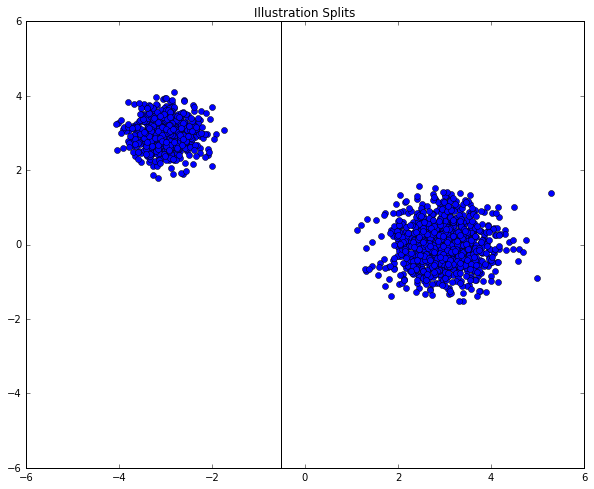

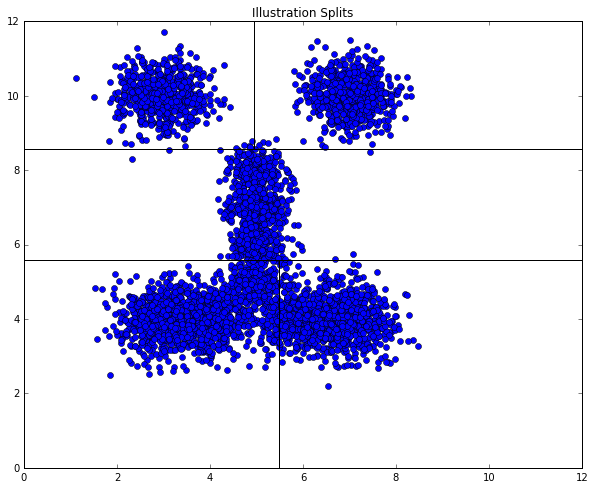

In [80]:
DensityTree7=RandomDensityTree(max_depth=5,min_infogain=1.5,num_splits=50,splittype='axis')
DensityTree7.fit(X_train)

plotaxis(X_train,DensityTree7,xlim=[-6,6],ylim=[-6,6],showcov=False,title='Illustration Splits')

DensityTree8=RandomDensityTree(max_depth=5,min_infogain=1.5,num_splits=50,splittype='axis')
DensityTree8.fit(obs)

plotaxis(obs,DensityTree8,xlim=[0,12],ylim=[0,12],showcov=False,title='Illustration Splits')

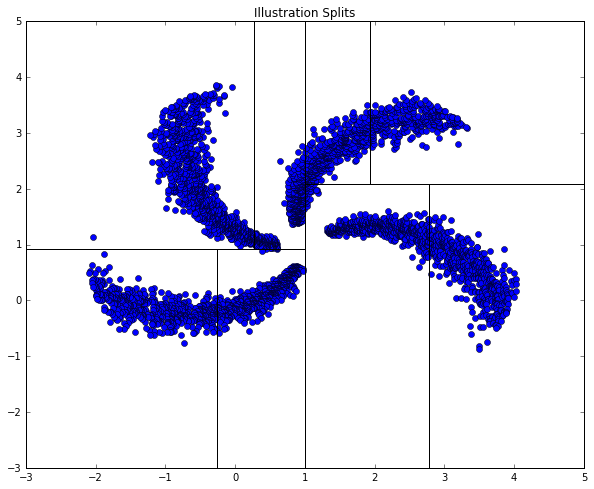

In [94]:
DensityTree9=RandomDensityTree(max_depth=3,min_infogain=0.05,num_splits=50,splittype='axis')
DensityTree9.fit(X3)
plotaxis(X3,DensityTree9,xlim=[-3,5],ylim=[-3,5],showcov=False,title='Illustration Splits')

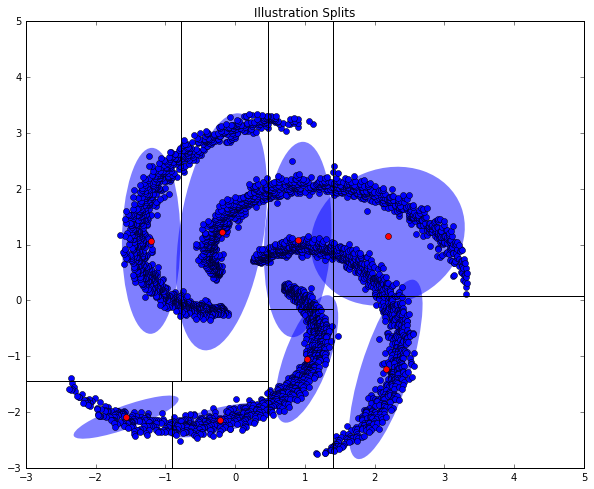

In [175]:
DensityTree10=RandomDensityTree(max_depth=3,min_infogain=0.05,num_splits=50,splittype='axis')
DensityTree10.fit(X4)
plotaxis(X4,DensityTree10,xlim=[-3,5],ylim=[-3,5],showcov=True,title='Illustration Splits')

0.596905548318
149.559180567
25.5820229478
40.3345781153
168.612822763
139.082678954
22.1253705089
14.1555083933


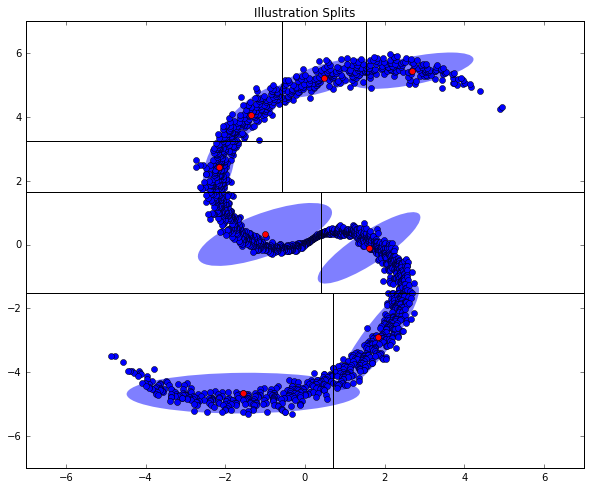

In [190]:
DensityTree11=RandomDensityTree(max_depth=3,min_infogain=0.05,num_splits=50,splittype='axis')
DensityTree11.fit(X5)
plotaxis(X5,DensityTree11,xlim=[-7,7],ylim=[-7,7],showcov=True,title='Illustration Splits')